In [1]:
import numpy as np

#For reading extxyz dataset
import ase
from ase.build import bulk
from ase.data import atomic_numbers, chemical_symbols

# QUIPPY, GAP package for SOAP descriptor
import quippy
from quippy import descriptors

# To save output descriptor data in h5 format
# and read it again in NN steps
import h5py

# unzip files
import gzip
import shutil

# To help on measuring time and iterations.
import time
import itertools

# We will use PyTorch for NN
import torch
import torch.nn as nn
import torch.nn.functional as F

# For sqrt function
import math

# For matrix inversion and least-squares
from pylab import *
from scipy.linalg import pinv2
from scipy.linalg import pinv
from scipy.optimize import leastsq

# Several Singular Value Decomposition methods used in CUR code
from numpy.linalg import svd as svd
from scipy.linalg import svd as s_svd
from sklearn.utils.extmath import randomized_svd


# For Principle Components Analysis
from sklearn.decomposition import PCA

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [39]:
def fmt_table(table):
    return '\n'.join([' '.join(['{: ^6}'.format(x) for x in row]) for row in table])

def calc_db_desc(ase_database, quip_desc, time_log=100, tolist=False):
    out_desc = []
    total_stime = time.time()
    for count, ase_structure in enumerate(ase_database):
        if count%int(time_log) == 0:
            start = time.time()
        desc_struct = quippy.Atoms(ase_structure)
        desc_struct.set_cutoff(quip_desc.cutoff())
        desc_struct.calc_connect()
        # Calculate descriptor
        rtn_desc = quip_desc.calc(desc_struct)
        if tolist:
            out_desc.append({
                "descriptors" : rtn_desc["descriptor"].tolist(),
                "symbols"     : ase_structure.get_chemical_symbols()
                })
        else:
            out_desc.append({
                "descriptors" : rtn_desc["descriptor"],
                "symbols"     : ase_structure.get_chemical_symbols()
                })
        if count%int(time_log) == int(time_log) - 1:
            end = time.time()
            print('Elapsed time for ' + str(count+1) + ' runs : ' + str(end - start))
    print('Total Elapsed time for ' + str(count+1) + ' runs : ' + str(time.time() - total_stime))
    return out_desc

def get_all_symbols(ase_data):
    symbols = []
    all_elements = list(itertools.chain.from_iterable([
        m.numbers for m in ase_data]))  # flattened list of all proton numbers Z in the dataset
    numbers = np.unique(all_elements)
    bins = np.bincount(all_elements)
    fractions = np.asarray([float(bin_num)/float(len(all_elements)) for bin_num in bins])
    for num in numbers:
        symbols.append(chemical_symbols[num])
    return symbols, numbers, fractions

def calc_desc(ase_database, desc, cutoff, rad_n_max, 
              ang_l_max, all_symbols, time_log=100, tolist=False, silent=False):
    out_desc = []
    if not silent: 
        total_stime = time.time()
    for count, ase_structure in enumerate(ase_database):
        if not silent and count%int(time_log) == 0:
            start = time.time()
        desc_struct = ase_structure
        # Calculate descriptor
        rtn_desc = desc.calc(desc_struct)
        if tolist:
            out_desc.append({
                "descriptors" : rtn_desc["data"].tolist(),
                "symbols"     : ase_structure.get_chemical_symbols()
                })
        else:
            out_desc.append({
                "descriptors" : rtn_desc["data"],
                "symbols"     : ase_structure.get_chemical_symbols()
                })
        if not silent and count%int(time_log) == int(time_log) - 1:
            end = time.time()
            print('Elapsed time for ' + str(count+1) + ' configurations : ' + str(end - start))
    if not silent:  
        print('Total Elapsed time for ' + str(count+1) + ' configurations : ' + str(time.time() - total_stime))
    return out_desc

def select_db_element(fingerprints, element=None):
    dbase = []
    if element:
        for item in fingerprints:
            for symi, sym in enumerate(item['symbols']):
                if element == sym:
                    dbase.append(item['descriptors'][symi])
    else:
        for item in fingerprints:
            for row in item['descriptors']:
                dbase.append(row)
    return np.array(dbase)

def write_h5(fname, dataset):
    with h5py.File(fname, 'w') as hf: 
        hf.create_dataset('dataset', data=dataset)
        
def read_h5(filename):
    with h5py.File(filename, 'r') as hf:
        data = hf['dataset'][:]
    return np.array(data)

def mul_cols(data, vec, axis=1):
    if axis==1:
        return np.multiply(data, vec)
    else:
        return np.multiply(data.T, vec).T

def normalize(data):
    maxs = np.amax(data)
    mins = np.amin(data)
    scales = maxs-mins
    return mins, scales, (data-mins)/scales

def standardize(data):
    means = np.mean(data)
    stds = np.std(data)
    print("Mean: ",means," Std: ",stds)
    return means, stds, (data-means)/stds

def randomize_data(data):
    data = np.random.randn(data.shape[0],data.shape[1])
    return np.ascontiguousarray(data, dtype=np.float64)

def allones_data(data):
    data = np.ones(data.shape)
    return np.ascontiguousarray(data, dtype=np.float64)

def normalize_data(data, axis=1):
    if axis==1:
        scale_axis=0
    else:
        scale_axis=1
    maxs = np.amax(data, axis=scale_axis)
    mins = np.amin(data, axis=scale_axis)
    scales = maxs-mins
    scales[scales==0.] = 1.
    return mul_cols(data-mins, 1./scales, axis=axis)

def standardize_data(data, axis=1):
    if axis==1:
        scale_axis=0
    else:
        scale_axis=1
    means = np.mean(data, axis=scale_axis)
    stds = np.std(data, axis=scale_axis)
    scales = np.ones(data.shape[1])
    scales[stds != 0.] = 1./stds[stds != 0.]
    return mul_cols(data-means, 1./scales, axis=axis)

def scale_data(data, scale=1., axis=1):
    return mul_cols(data, np.array([scale for a in range(data.shape[axis])]), axis=axis)


class MLDATA(object):
    def __init__(self, data, targets, split_list=None, percent=0.8, use_l2=False, 
                 nfeatures=None, toglobal=False, norm_data=0, use_mean=False):
        self.data = data
        if nfeatures is None:
            self.nfeatures = data.shape[1] 
        else:
            self.nfeatures = nfeatures
        self.means = None
        self.use_mean = use_mean
        self.stds = None
        self.mins = None 
        self.scales = None
        self.natoms = targets[:,0]
        if data.shape[0] == targets.shape[0]:
            self.glob_desc=True
            if norm_data == 1:
                self.mins, self.scales, self.targets = normalize(targets[:,1])
            if norm_data == 2:
                self.means, self.stds, self.targets = standardize(targets[:,1])
            else:
                self.targets = targets[:,1]
            self.N = len(self.targets)
        else:
            self.glob_desc=False
            self.slice_list = targets[:,0]
            if norm_data == 1:
                self.mins, self.scales, self.targets = normalize(targets[:,1])
            if norm_data == 2:
                self.means, self.stds, self.targets = standardize(targets[:,1])
            else:
                self.targets = targets[:,1]
            self.N = len(self.targets)
            self.slices = self.slice_array()
            if toglobal:
                self.glob_desc=True
                self.data = self.make_global_representation()
                print("Reduced shape: ",self.data.shape)
        self.tr, self.tt = self.split_test_train(
                                split_list=split_list,
                                perc=percent)
        self.rN = len(self.tr)
        self.tN = len(self.tt)
        print("Dataset is splitted to ",self.rN,
              " and ",self.tN," for training and test.")

    def make_global_representation(self):
        sl = self.slices[:,0]
        print("Data shape before reduce: ",self.data.shape)
        return np.add.reduceat(self.data, sl)

    def slice_array(self):
        slices = np.zeros((self.N,2), dtype=int)
        i = 0
        for si, s in enumerate(self.slice_list[:self.N]):
            slices[si][0]=i
            i+=s
            slices[si][1]=i
        slices[-1][1] -= 1
        return slices
  
    def split_test_train(self, split_list=None, perc=0.8):
        if split_list is not None:
            Ntr = int(split_list[0])
            print("Using splitted dataset to ",int(Ntr)," and ",int(self.N-Ntr),
                  " for training and testing.")
            return (np.array(split_list[1:int(Ntr+1)], dtype=int),
                    np.array(split_list[int(Ntr+1):], dtype=int))
        else:
            rand_list = np.arange(self.N)
            np.random.shuffle(rand_list)
            Ntr = np.rint(self.N * perc)
            print("Splitting dataset to ",int(Ntr)," and ",int(self.N-Ntr),
                  " for training and testing.")
            np.savetxt("split_list_indices.txt",rand_list.astype(int), fmt='%i')
            print("Split list is saved to split_list_indices.txt file.")
            return rand_list[:int(Ntr)].copy(), rand_list[int(Ntr):].copy()

    def linear_kernel(self, test=True):
        sl = self.tt if test else self.tr
        if self.glob_desc:
            return self.data[sl,:]
        else:
            X = np.zeros(len(sl),len())
            for i,j in zip(range(len(sl)),range(len.sl)):
                X[i,j] = self.data[sl[i],:].T.dot(self.data[sl[j],:])
            return X

    def train_natoms(self, i=None, j=None):
        if i is None:
            return self.natoms[self.tr]
        else:
            if j is None:
                return self.natoms[self.tr[i]]
            else:
                return self.natoms[self.tr[i:j]]

    def test_natoms(self, i=None, j=None):
        if i is None:
            return self.natoms[self.tt]
        else:
            if j is None:
                return self.natoms[self.tt[i]]
            else:
                return self.natoms[self.tt[i:j]]

    def get_dataset(self, id_list):
        sel = []
        for i in id_list:
            sel.extend(np.arange(
                int(self.slices[i][0]),
                int(self.slices[i][1])
            ))
        return self.data[sel,:]          
            
    def train(self, i=None, j=None, sublist=None, cols=None):
        if cols is None:
            cols = np.arange(self.data.shape[1])
        if sublist is not None:
                sel = []
                for i in sublist:
                    sel.append(torch.tensor(self.data[np.arange(
                            int(self.slices[i][0]),
                            int(self.slices[i][1])
                            ),:][:,cols], dtype=torch.double).unsqueeze(0))
                return sel           
        elif i is None:
            if self.glob_desc:
                return torch.tensor(self.data[self.tr,:][:,cols], 
                                    dtype=torch.double).unsqueeze(1)
            else:
                sel = []
                for i in self.tr:
                    sel.append(torch.tensor(self.data[np.arange(
                            int(self.slices[i][0]),
                            int(self.slices[i][1])
                            ),:][:,cols], dtype=torch.double).unsqueeze(0))
                return sel
        else:
            if self.glob_desc:
                if j is None:
                    return torch.tensor(self.data[self.tr[i],:][:,cols]).unsqueeze(1)
                else:
                    return torch.tensor(self.data[self.tr[i:j,:]][:,cols]).unsqueeze(1)
            else:
                si,sj = self.slices[self.tr[i]]
                if sj >= self.data.shape[0]:
                    return torch.tensor(self.data[si:,:][:,cols]).unsqueeze(0)
                else:
                    return torch.tensor(self.data[si:sj,:][:,cols]).unsqueeze(0)

    def test(self, i=None, j=None, sublist=None, cols=None):
        if cols is None:
            cols = np.arange(self.data.shape[1])
        if sublist is not None:
                sel = []
                for i in sublist:
                    sel.append(torch.tensor(self.data[np.arange(
                            int(self.slices[i][0]),
                            int(self.slices[i][1])
                            ),:][:,cols], dtype=torch.double).unsqueeze(0))
                return sel           
        elif i is None:
            if self.glob_desc:
                return torch.tensor(self.data[self.tt,:][:,cols], 
                                    dtype=torch.double).unsqueeze(1)
            else:
                sel = []
                for i in self.tt:
                    sel.append(torch.tensor(self.data[np.arange(
                            int(self.slices[i][0]),
                            int(self.slices[i][1])
                            ):,][:,cols], dtype=torch.double).unsqueeze(0))
                return sel
        else:
            if self.glob_desc:
                if j is None:
                    return torch.tensor(self.data[self.tt[i],:][:,cols], 
                                        dtype=torch.double).unsqueeze(1)
                else:
                    return torch.tensor(self.data[self.tt[i:j,:]][:,cols], 
                                        dtype=torch.double).unsqueeze(1)
            else:
                si,sj = self.slices[self.tt[i]]
                if sj >= self.data.shape[0]:
                    return torch.tensor(self.data[si:,:][:,cols], 
                                        dtype=torch.double).unsqueeze(0)
                else:
                    return torch.tensor(self.data[si:sj,:][:,cols], 
                                        dtype=torch.double).unsqueeze(0)
    
    def target(self, i=None, j=None, sublist=None):
        if sublist is not None:
            return torch.tensor(self.targets[sublist], dtype=torch.double)
        elif i is None:
            return torch.tensor(self.targets[self.tr], dtype=torch.double)
        else:
            if j is None:
                return torch.tensor(self.targets[self.tr[i]], dtype=torch.double)
            else:
                return torch.tensor(self.targets[self.tr[i:j]], dtype=torch.double)
    
    def test_target(self, i=None, j=None, sublist=None):
        if sublist is not None:
            return torch.tensor(self.targets[sublist], dtype=torch.double)
        elif i is None:
            return torch.tensor(self.targets[self.tt], dtype=torch.double)
        else:
            if j is None:
                return torch.tensor(self.targets[self.tt[i]], dtype=torch.double)
            else:
                return torch.tensor(self.targets[self.tt[i:j]], dtype=torch.double)

def get_train_ids(thedata, selected_index):
    phase_train_ids = []
    for tri in thedata.tr:
        if tri in selected_index:
            phase_train_ids.append(tri)
    return phase_train_ids

def get_test_ids(thedata, selected_index):
    phase_test_ids = []
    for tti in thedata.tt:
        if tti in selected_index:
            phase_test_ids.append(tti)
    return phase_test_ids

def get_structures(structure_type, structure_names):
    all_indicies = []
    for row in structure_type:
        if row[1] in structure_names:
            all_indicies.append(row[0])
    return all_indicies

def reduce_list(the_ids, percent=0.5):
    arr_ids = np.array(the_ids)
    nums = int(len(arr_ids) * percent)
    arr_ns = np.arange(len(arr_ids))
    np.random.shuffle(arr_ns)
    return arr_ids[arr_ns[:nums]]

def get_dataset(dataset, id_list):
    sel = []
    for i in id_list:
        sel.extend(np.arange(
            int(dataset.slices[i][0]),
            int(dataset.slices[i][1])
        ))
    return dataset.data[sel,:]

In [40]:
#Succesive Principle Component Reduction
# SPCR
class SPCR(object):
    def __init__(self, data, dim=None, verbose=False, save=False, save_name=None):
        self.data = data[:,:]
        self.data_shape = data.shape
        self.model = None
        if dim is not None:
            self.newdim = dim
        else:
            self.newdim = data.shape[1]
        self._verbose = verbose
        self._save = save
        if save_name is None:
            self.save_name = 'DATA_PCA_save'
        else:
            self.save_name = save_name
        self.nodata_files = True
        self.initial_feature_ids = np.array(range(self.data_shape[1]))
        self.pinv_data = None
        self.XXp = None
        self.norm_data = None
        
    def verbose(self, verbose=None):
        rtn = False
        if verbose is not None:
            if verbose:
                rtn =  True
        elif self._verbose:
            rtn = True
        return rtn
    
    def save(self, save=None):
        rtn = False
        if save is not None:
            if save:
                rtn =  True
        elif self._save:
            rtn = True
        return rtn

    def write(self, fname, data, msg=None, verbose=None):
        if self.verbose(verbose=verbose):
            if msg is None:
                msg = 'Writting data into '
            print(msg+str(fname)+' file.')
            sys.stdout.flush()
        np.savetxt(fname, data) 
        if self.verbose(verbose=verbose):
            print('File is written.')
  
    def fit(self, verbose=None):
        if self.verbose(verbose=verbose):
            print('Calculating averages and shifting data...')
        if self.verbose(verbose=verbose):
            print('Fitting PCA with data...')
        self.dataAvg = np.mean(self.data, axis=0)
        self.data = self.data - self.dataAvg[:,None].T
        self.model=PCA(n_components=self.newdim,copy=True)
        self.model.fit(self.data)
        if self.verbose(verbose=verbose):
            print('The explained variance ratios :')
            for ratio in self.model.explained_variance_ratio_:
                print(ratio)
        if self.save():
            outputname = self.save_name            
            self.write(outputname+'_VARRATIOS', 
                       self.model.explained_variance_ratio_, 
                       msg='Writing variance ratios to ',
                       verbose=verbose)
            self.write(outputname+'_VARIANCES',
                       self.model.explained_variance_,
                       msg='Writing variances to ',
                       verbose=verbose)
        if self.verbose(verbose=verbose):
            print('The total variance explained is {0}'.format(np.sum(self.model.explained_variance_ratio_)))
            
    def factorize(self, verbose=False, plot=True, errors=False):
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.ion()
            ax.set_xlabel('Number of features')
            if errors:
                ax.set_ylabel('||V_{all} - V_{sel}||')
            else:
                ax.set_ylabel('Variance')
            fig.show()
            fig.canvas.draw()
        self._colid = []
        full_vars = []
        var_scale = 1.0
        self.data2 = self.data[:,:]
        self.newdim2 = self.newdim
        self._save=True
        self.errors = []
        current_ids = np.array(self.initial_feature_ids[:])
        for i in range(self.data_shape[1]):
            if i < self.data_shape[1]:
                self.data = self.data2[:,current_ids]
                self.fit()
            if i>0:
                self._save=False
            if i < self.data_shape[1]-1:
                sel = np.abs(self.model.components_[0]).argmax()
                current_var = np.abs(self.model.components_[0][sel])*self.model.explained_variance_ratio_[0]*var_scale
                var_scale -= current_var
                pc_v = self.model.explained_variance_ratio_[0]
            else:
                sel = 0
                current_var = var_scale
                var_scale -= current_var
                pc_v = 1.0
            if not plot and self.verbose(verbose=verbose):
                print("iter: ",i+1,
                      " sel: ",sel,
                      " col : ",current_ids[sel], 
                      " pc_v: ",pc_v,
                      " var: ",current_var,
                      " scale: ",var_scale)
            full_vars.append(current_var)
            self._colid.append(current_ids[sel])
            current_ids = np.delete(current_ids, sel, 0)
            self._cid = np.array(self._colid, np.int32)
            if errors:
                if not plot and self.verbose(verbose=verbose):
                    print('[CUR:] Applying CUR Decomposition with Selected C and R=X ...')
                self.computeUCR(verbose=verbose, plot=plot, factorize=True)
                self.errors.append(self.error)
                if not plot and self.verbose(verbose=verbose):
                    print('[CUR:] Error between X and X` = CUR : ' + str(self.error))
            else:
                self.errors = full_vars
            if plot:
                ax.clear()
                ax.plot(np.arange(i+1)+1,self.errors)
                ax.set_yscale("log")
                ax.set_xlabel('Number of features')
                if errors:
                    ax.set_ylabel('||V_{all} - V_{sel}||')
                else:
                    ax.set_ylabel('Variance')
                fig.canvas.draw()
            self.newdim -= 1
        self.data = self.data2[:,:]
        self.newdim = self.newdim2
        return self._colid, full_vars
        
    def transform(self, save=None, verbose=None, save_name=None):
        if self.verbose(verbose=verbose):
            print('Applying PCA on Dataset.')
        self.data = self.model.transform(self.data) # apply PCA transform to data
        if self.verbose(verbose=verbose):
            print('Transformation is completed.')
        if save_name is not None:
            outputname = save_name
        else:
            outputname = self.save_name
        if self.nodata_files is False:
            self.write(outputname+'.gz', self.data, msg='Writing '+' x '.join([
                str(s) for s in np.shape(self.data)
                ])+' PCA transformed DATA to ', verbose=verbose)
        if self.save(save=save):
            self.write(outputname+'_COVMAT.gz', self.model.components_, msg='Writing '+' x '.join([
                    str(s) for s in np.shape(self.model.components_)
                    ])+' covariant matrix to ', verbose=verbose)

    def standardize(self, verbose=None, save=None, save_name=None):
        self.std_devs = np.std(self.data, axis=0)
        self.data = self.data / self.std_devs[:,None].T
        self.std_scale = np.mean(np.linalg.norm(self.data,axis=1))
        if self.verbose(verbose=verbose):
            print('After standardizing, the average L2 norm of data is', self.std_scale)
        if self.save(save=save):
            if save_name is not None:
                outputname = save_name
            else:
                outputname = self.save_name
            if self.nodata_files is False:
                self.write(outputname+'_STD.gz', self.data, msg='Writing '+' x '.join([
                    str(s) for s in np.shape(self.data)
                    ])+' Standardized PCA DATA to ', verbose=verbose)
            self.write(outputname+'_STD_DEVS', self.std_devs[:,None], 
                       msg='Writing standard deviations of columns for data into ',
                       verbose=verbose)

    def normalize(self, verbose=None, save=None, save_name=None):
        self.norm_vals = np.maximum(self.data) - np.minimum(self.data)
        self.data = self.data / self.norm_vals[:,None].T 
        self.norm_scale=np.mean(np.linalg.norm(self.data,axis=1))
        if self.verbose(verbose=verbose):
            print('After normalization, the average L2 norm of data is', self.norm_scale)
        if self.save(save=save):
            if save_name is not None:
                outputname = save_name
            else:
                outputname = self.save_name
            if self.nodata_files is False:
                self.write(outputname+'_NORM.gz', self.data, msg='Writing '+' x '.join([
                       str(s) for s in np.shape(self.data)
                       ])+' Normalized PCA DATA to ', verbose=verbose)
            self.write(outputname+'_NORM_VALS', self.norm_vals[:,None], 
                       msg='Writing scaling (max-min) of columns for data into ',
                       verbose=verbose)

    def importance(self, verbose=None, save=None, save_name=None):
        # Following the codes and discussions here:
        # https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697
        initial_feature_ids = np.array(range(self.data.shape[1]))
        self.num_pcs= self.model.components_.shape[0]
        self.most_important_pcs = np.array([np.array(np.abs(self.model.components_[i]).argsort()[::-1][:1]) for i in range(self.num_pcs)])
        self.most_important_features = [initial_feature_ids[self.most_important_pcs[i]] for i in range(self.num_pcs)]
        self.important_features = {'PC{}'.format(i+1): ','.join([str(s) for s in self.most_important_features[i]]) for i in range(self.num_pcs)}
        
    def computeUCR(self, verbose=False, plot=True, factorize=False):

        if self.pinv_data is None:
            if verbose and not plot:
                start = time.time()
            if factorize:
                self.pinv_data = pinv(self.data2[:,:])
            else:
                self.pinv_data = pinv(self.data[:,:])                
            if verbose and not plot:
                end = time.time()
                print('Elapsed time for pseudo-inverse of data : ' + str(end - start))

        if self.XXp is None: # XX*
            if verbose and not plot:
                start = time.time()
            if factorize:
                self.XXp = np.dot(self.data2[:,:], self.pinv_data)
            else:
                self.XXp = np.dot(self.data[:,:], self.pinv_data)
            if verbose and not plot:
                end = time.time()
                print('Elapsed time for XXp multiplication: ' + str(end - start))

        if verbose and not plot:
            start = time.time()
        if factorize:
            self._C = self.data2[:, self._cid] # C
            self._R = self.data2 # R = X
        else:
            self._C = self.data[:, self._cid] # C
            self._R = self.data # R = X           
        self._U = np.dot(pinv2(self._C), self.XXp) # C*XX*

        if self.norm_data is None:
            if factorize:
                self.norm_data = np.linalg.norm(self.data2)
            else:
                self.norm_data = np.linalg.norm(self.data)
        if factorize:
            self.error = np.linalg.norm(self.data2 - np.dot(
                np.dot(self._C, self._U), self._R)) / self.norm_data
        else:
            self.error = np.linalg.norm(self.data - np.dot(
                np.dot(self._C, self._U), self._R)) / self.norm_data
            
        if verbose and not plot:
            end = time.time()
            print('Elapsed time for error calculation with CUR : ' + str(end - start))

In [41]:
# Fingerprint dimension reduction with CUR
class FPCUR(object):
    """
    """

    def __init__(self, data, pk=-1, k=1, N=0, col_weights=None, error_print=0, nonan=False):
        """
        Parameters
        ----------
        """
        (rows, cols) = data.shape
        self.data = data
        self.pinv_data = None
        self.XXp = None
        self.norm_data = None
        self.norm1_data = None
        self.norm2_data = None
        self.norm3_data = None
        self._rows = rows
        self._cols = cols
        self.sk = k
        self.nonan = nonan
        self._col_weights = col_weights

        if N < 1:
            self._N = self._cols
        else:
            self._N = N

        if error_print < 1:
            self.error_print = self._N
        else:
            self.error_print = int(error_print)

    def importance_score(self):
        dsquare = self.svd_V[:,:]**2
        pi_cols = np.sum(dsquare[range(self.sk),:], axis=0)
        if self._col_weights is not None:
            pi_cols *= self._col_weights
        return pi_cols

    def max_score(self):
        pi_cols = self.importance_score()
        pi_max = np.argmax(pi_cols, axis=0)
        return pi_max, pi_cols

    def ortho_vec(self, X, X_l, X_l_norm2):
        return X - X_l * np.dot(X_l, X) / X_l_norm2

    def orthogonalize(self, col=0):
        if self.nonan:
            print('[CUR:] Changing NaN and Inf before orthogonalization.')
            self._X = np.nan_to_num(self._X)
        l_col = self._X[:, col]
        l_col_norm2 = np.linalg.norm(l_col) ** 2
        self._X = np.apply_along_axis(self.ortho_vec, 0, self._X, l_col, l_col_norm2)

    def computeUCR(self):
        self._ccnt = np.ones(len(self._cid))

        if self.pinv_data is None:
            start = time.time()
            self.pinv_data = pinv(self.data[:,:])
            end = time.time()
            print('Elapsed time for pseudo-inverse of data : ' + str(end - start))
            sys.stdout.flush()

        if self.XXp is None: # XX*
            start = time.time()
            self.XXp = np.dot(self.data[:,:], self.pinv_data)
            end = time.time()
            print('Elapsed time for XXp multiplication: ' + str(end - start))
            sys.stdout.flush()

        start = time.time()
        self._C = self.data[:, self._cid] # C
        self._R = self.data # R = X
        self._U = np.dot(pinv2(self._C), self.XXp) # C*XX*

        if self.norm_data is None:
            self.norm_data = np.linalg.norm(self.data)

        self.error = np.linalg.norm(self.data - np.dot(
            np.dot(self._C, self._U), self._R)) / self.norm_data
        end = time.time()
        print('Elapsed time for error calculation with CUR : ' + str(end - start))
        sys.stdout.flush()

    def reset(self):
        self._first_feature_no = None
        self.pinv_data = None
        self.XXp = None
        self.norm_data = None
        self.norm1_data = None
        self.norm2_data = None
        self.norm3_data = None
        self._cid = []
        

    def factorize(self):
        """ Factorize s.t. CUR with fingerprint feature selection = data

        Updated Values
        --------------
        ._C (.U): updated values for C.
        ._U (.S): updated values for U.
        ._R (.V): updated values for R.
        """

        self._X = self.data.copy()
        self._colid = []
        all_errors = []
        all_cids = []

        print('[CUR:] Selecting Columns for C Matrix from X data ...')
        for s in range(self._N):
            print('[CUR:] Cycle No : ' + str(s+1))
            sys.stdout.flush()
            print('[CUR:] SVD Decomposition ...')
            sys.stdout.flush()
            start = time.time()
            if self.nonan:
                print('[CUR:] Changing NaN and Inf before SVD Decomposition.')
                self._X = np.nan_to_num(self._X)
            try:
                self.svd_U, self.svd_S, self.svd_V = randomized_svd(self._X, 
                                                                    n_components=500,
                                                                    n_iter=10,
                                                                    random_state=None)
            except ValueError:
                self.svd_U, self.svd_S, self.svd_V = s_svd(self._X, full_matrices=True)
            end = time.time()
            print('Elapsed time for SVD Decomposition: ' + str(end - start))
            print('[CUR:] Importance Scoring ...')
            sys.stdout.flush()
            pi_cols = self.importance_score()
            print('[CUR:] Length of scores : ',len(pi_cols))
            for ci in range(len(pi_cols)):
                pi_max = np.nanargmax(pi_cols, axis=0)
                if pi_max not in self._colid:
                    print('[CUR:] non-recurrence col cycle:',ci,pi_max)
                    break
                else:
                    pi_cols[pi_max] = np.nan
            print('[CUR:] Orthogonalization ...')
            sys.stdout.flush()
            self.orthogonalize(col=pi_max)
            print('[CUR:] Selected Column Number : ' + str(pi_max))
            sys.stdout.flush()
            self._colid.append(pi_max)
            self._cid = np.array(self._colid, np.int32)
            if s == 0 or s == self._N-1 or s % self.error_print == 0:
                self._ccnt = np.ones(len(self._cid))
                print('[CUR:] Non-recurrent Selection size of C : ' + str(len(list(set([c for c in self._cid])))))
                print('[CUR:] Applying CUR Decomposition with Selected C and R=X ...')
                sys.stdout.flush()
                self.computeUCR()
                print('[CUR:] Error between X and X` = CUR : ' + str(self.error))
                sys.stdout.flush()
                all_cids.append(self._colid[:])
                all_errors.append([self.error])

        return all_cids, all_errors

In [42]:
# NN model including Implanted Neural Network scheme

class NNmodel(nn.Module):

    def __init__(self, desc_size=451, hidden_size=35, implant_net=None):
        super(NNmodel, self).__init__()
        self.implanted = False
        self.hidden_size = hidden_size
        self.input_size = desc_size
        self.implant_layer_weight = []
        self.implant_layer_bias = []
        if (implant_net is not None):
            self.implanted = True
            for k,v in implant_net._modules.items():
                if(len(v._parameters.keys())>0):
                    self.implant_layer_weight.append(implant_net._modules[k]._parameters["weight"].data[:,:])
                    self.implant_layer_bias.append(implant_net._modules[k]._parameters["bias"].data[:])
            self.implant_size = self.implant_layer_weight[0].shape[0]
            self.hidden_size += self.implant_size
        # Input descriptor vector size to 1st hidden layer
        self.layer1 = nn.Linear(self.input_size, self.hidden_size)
        self.act1 = nn.Tanh()
        # Input to 2nd hidden layer
        self.layer2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.act2 = nn.Tanh()        
        # 3rd output layer to atom energy
        self.layer3 = nn.Linear(self.hidden_size, 1)
        
    def implant(self):
        layer=0
        for k,v in self._modules.items():
            if(len(v._parameters.keys())>0):
                in_n = self.implant_layer_weight[layer].data.shape[0]
                out_n = self.implant_layer_weight[layer].data.shape[1]
                self._modules[k]._parameters["weight"].data[
                    :in_n,:out_n] = self.implant_layer_weight[layer][:,:]
                self._modules[k]._parameters["bias"].data[
                    :in_n] = self.implant_layer_bias[layer][:]
                layer+=1

    def forward(self, x):
        if self.implanted:
            self.implant()
        xx = torch.zeros(len(x), dtype=torch.double)
        for k in range(len(x)):
            xx[k] = torch.sum(self.layer3(self.layer2(self.layer1(x[k]))), 1)
        return xx


In [3]:
xyz_data_filename = "Si.extxyz"
h5fname = xyz_data_filename+'.h5'

with gzip.open(xyz_data_filename+'.gz', 'rb') as f_in:
    with open(xyz_data_filename, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [43]:
ase_db = ase.io.read(xyz_data_filename, index=':')
print('Number of structures : ' + str(len(ase_db)))

all_syms, all_nums, all_fractions = get_all_symbols(ase_db)
all_elements = [e for e in all_nums]
print('Elemental composition:\n' + fmt_table([
        all_syms, 
        all_nums,
        [str(100.0*per)+'%' for per in np.round(all_fractions[all_elements], len(all_nums))]
        ]))

Number of structures : 3583
Elemental composition:
  Si  
  14  
100.0%


In [44]:
ase_db[0]

Atoms(symbols='Si', pbc=True, cell=[20.0, 20.0, 20.0], dft_force=..., gap_force=..., map_shift=..., n_neighb=...)

In [45]:
# Optional step:
#   Either regenerate the SOAP descriptor dataset for the given input 
#   structure set here or run the next step to load a pregenerated dataset.
#
# Generate SOAP Descriptors for the dataset

sigma = 0.5
cutoff = 6.5 # <-- check this value before start!!!
rad_n_max = 9
ang_l_max = 9
normalise = True
cross_over = True

#soap_desc = soaplite.get_soap_structure
desc_definition = ("soap" 
                   " cutoff=" + str(cutoff) +
                   " l_max=" + str(ang_l_max) +
                   " n_max=" + str(rad_n_max) +
                   " atom_sigma=" + str(sigma) +
                   " normalise=" + ('T' if normalise else 'F') + 
                   " n_Z=" + str(len(all_nums)) +
                   " Z={" + " ".join([str(nm) for nm in all_nums]) + "}" + 
                   " n_species=" + str(len(all_nums)) +
                   " species_Z={" + " ".join([str(nm) for nm in all_nums]) + "}")
soap_desc = descriptors.Descriptor(desc_definition)

In [46]:
print('----- Calculating SOAP Descriptors -----')
fingerprints = calc_desc(ase_db, soap_desc, 
                         cutoff, rad_n_max, ang_l_max, 
                         all_elements)
print('Extracting all atom descriptors...')
database = select_db_element(fingerprints)
print('Database size : ' + ' x '.join([ str(s) for s in database.shape]))

print('Writing descriptor data tensor to '+h5fname+' file.')
write_h5(h5fname, database)
print('File is saved.')

In [47]:
#Load pre-generated SOAP descriptors for the dataset
database = read_h5(h5fname)

In [48]:
# Get target energies from structure info
structure_type = []
target_values = []
number_of_atoms = []
for aci, ase_conf in enumerate(ase_db):
    atoms = len(ase_conf)
    ener_str = " "+str(aci)+" "+str(atoms)
    number_of_atoms.append(atoms)
    if "config_type" in ase_conf.info:
        ener_str += "  "+str(ase_conf.info["config_type"])
        structure_type.append([aci, ase_conf.info["config_type"]])
    if "dft_energy" in ase_conf.info:
        ener_str += " DFT energy: "+str(ase_conf.info["dft_energy"])
        target_values.append([aci, ase_conf.info["dft_energy"]])
    elif "DFT_energy" in ase_conf.info:
        ener_str += " DFT energy: "+str(ase_conf.info["DFT_energy"])
        target_values.append([aci, ase_conf.info["DFT_energy"]])
    elif "energy" in ase_conf.info:
        ener_str += "     energy: "+str(ase_conf.info["energy"])
        target_values.append([aci, ase_conf.info["energy"]])
    if "gap_energy" in ase_conf.info:
        ener_str += " GAP energy: "+str(ase_conf.info["gap_energy"])
    if aci<10:
        print(ener_str)

 0 1  isolated_atom DFT energy: -158.54496821 GAP energy: -157.7272532
 1 1  sh DFT energy: -162.78192
 2 1  sh DFT energy: -162.666465
 3 1  sh DFT energy: -162.748051
 4 1  sh DFT energy: -162.699367
 5 1  sh DFT energy: -162.704259
 6 1  sh DFT energy: -162.746046
 7 1  sh DFT energy: -162.765282
 8 1  sh DFT energy: -162.758977
 9 1  sh DFT energy: -162.684201


In [49]:
set(np.asarray(structure_type)[:,1])

{'111adatom',
 'amorph',
 'bc8',
 'bcc',
 'bt',
 'crack_110_1-10',
 'crack_111_1-10',
 'decohesion',
 'dia',
 'divacancy',
 'fcc',
 'hcp',
 'hex_diamond',
 'interstitial',
 'isolated_atom',
 'liq',
 'screw_disloc',
 'sh',
 'sp',
 'sp2',
 'st12',
 'surface_001',
 'surface_110',
 'surface_111',
 'surface_111_3x3_das',
 'surface_111_pandey',
 'vacancy'}

In [50]:
#Taken from 
# https://github.com/libAtoms/testing-framework/blob/public/example_models/Si/run_dir/Si-model-CASTEP_ASE-test-bulk_Si_diamond-properties.json
CASTEP_Si_diamond_properties = {
    "B": 88.596696666666602, "c12": 56.25008999999995, "c11": 153.28990999999988, 
    "E_vs_V": [[17.813109023568057, -163.06663280425], 
               [18.322054995670012, -163.110046112], 
               [18.831000967771949, -163.1415028745], 
               [19.339946939873919, -163.162464704125], 
               [19.848892911975845, -163.174242557], 
               [20.3578388840778, -163.177966801875], 
               [20.866784856179741, -163.17463056225], 
               [21.375730828281693, -163.165132595375], 
               [21.884676800383637, -163.150242437875], 
               [22.393622772485578, -163.130671150875], 
               [22.902568744587512, -163.107009425875], 
               [23.411514716689464, -163.079814823625]], 
    "c44": 72.176929999999999, "a0": 5.4610215037046075}

GAP_Si_diamond_properties = {
    "B": 88.810217439942406, "c12": 57.523403533287755, "c11": 151.38384525325171, 
    "E_vs_V": [[17.810988598616127, -163.0664086908508], 
               [18.319873987148007, -163.10988532610546], 
               [18.828759375679891, -163.14135897170343], 
               [19.337644764211802, -163.1623186809442], 
               [19.846530152743675, -163.17407908173888], 
               [20.355415541275576, -163.17779158878503], 
               [20.86430092980746, -163.1744678303302], 
               [21.373186318339357, -163.16500928944993], 
               [21.882071706871262, -163.15020272752062], 
               [22.390957095403131, -163.1306956287047], 
               [22.899842483935011, -163.10696484343256], 
               [23.408727872466905, -163.07932039246145]], 
    "c44": 67.863738907524706, "a0": 5.4608048066315646}

In [51]:
si_bulk_dia = bulk("Si", a=CASTEP_Si_diamond_properties["a0"])
len(si_bulk_dia)

2

In [52]:
from ase import Atoms

In [172]:
CASTEP_structures = []
CASTEP_energies = np.array(CASTEP_Si_diamond_properties["E_vs_V"])[:,1]
V0 = si_bulk_dia.get_volume()
dV = 0.025
nsteps = [-5, 6]
dV *= V0
E_vs_V=[]

scaled_bulk = si_bulk_dia.copy()
for i in range(0, nsteps[0]-1, -1):
    V_cur = scaled_bulk.get_volume()
    scaled_bulk.set_cell(scaled_bulk.get_cell()*((V0+i*dV)/V_cur)**(1.0/3.0), scale_atoms=True)
    CASTEP_structures.append(scaled_bulk)
    E_vs_V.insert(0, (scaled_bulk.get_volume()/len(scaled_bulk) ) )
                  
scaled_bulk = si_bulk_dia.copy()
for i in range(1, nsteps[1]+1):
    V_cur = scaled_bulk.get_volume()
    scaled_bulk.set_cell(scaled_bulk.get_cell()*((V0+i*dV)/V_cur)**(1.0/3.0), scale_atoms=True)
    CASTEP_structures.append(scaled_bulk)
    E_vs_V.append((scaled_bulk.get_volume()/len(scaled_bulk) ) )

for ai, at in enumerate(CASTEP_structures):
    CASTEP_energies[ai] *= len(at)

In [173]:
np.linalg.norm(np.array(E_vs_V) - np.array(CASTEP_Si_diamond_properties["E_vs_V"])[:,0])

4.365647657580676e-14

In [174]:
CASTEP_energies

array([-326.13326561, -326.22009222, -326.28300575, -326.32492941,
       -326.34848511, -326.3559336 , -326.34926112, -326.33026519,
       -326.30048488, -326.2613423 , -326.21401885, -326.15962965])

In [175]:
CASTEP_selected = np.arange(len(CASTEP_energies))
#CASTEP_selected = np.array([2,5,9])

In [176]:
phases1 = ["fcc", "bcc", "hcp", "dia", "bc8", "bt", "hex_diamond"]
phases2 = ["decohesion", "divacancy", "interstitial", "screw_disloc",
           "sp", "sp2", "st12", "vacancy", "sh"]
phases3 = ["amorph", "liq", "surface_001", "surface_110", "surface_111", 
           "crack_110_1-10", "crack_111_1-10", 
           "surface_111_3x3_das", "surface_111_pandey", "111adatom"]

INNphase0 = ["sh"]
INNphase1 = ["fcc", "bcc", "hcp", "hex_diamond"]
INNphase2 = ["amorph", "liq", "dia"]

In [177]:
structure_type

[[0, 'isolated_atom'],
 [1, 'sh'],
 [2, 'sh'],
 [3, 'sh'],
 [4, 'sh'],
 [5, 'sh'],
 [6, 'sh'],
 [7, 'sh'],
 [8, 'sh'],
 [9, 'sh'],
 [10, 'sh'],
 [11, 'sh'],
 [12, 'sh'],
 [13, 'sh'],
 [14, 'sh'],
 [15, 'sh'],
 [16, 'sh'],
 [17, 'sh'],
 [18, 'sh'],
 [19, 'sh'],
 [20, 'sh'],
 [21, 'sh'],
 [22, 'sh'],
 [23, 'sh'],
 [24, 'sh'],
 [25, 'sh'],
 [26, 'sh'],
 [27, 'sh'],
 [28, 'sh'],
 [29, 'sh'],
 [30, 'sh'],
 [31, 'sh'],
 [32, 'sh'],
 [33, 'sh'],
 [34, 'sh'],
 [35, 'sh'],
 [36, 'sh'],
 [37, 'sh'],
 [38, 'sh'],
 [39, 'sh'],
 [40, 'sh'],
 [41, 'sh'],
 [42, 'sh'],
 [43, 'sh'],
 [44, 'sh'],
 [45, 'sh'],
 [46, 'sh'],
 [47, 'sh'],
 [48, 'sh'],
 [49, 'sh'],
 [50, 'sh'],
 [51, 'sh'],
 [52, 'sh'],
 [53, 'sh'],
 [54, 'sh'],
 [55, 'sh'],
 [56, 'sh'],
 [57, 'sh'],
 [58, 'sh'],
 [59, 'sh'],
 [60, 'sh'],
 [61, 'sh'],
 [62, 'sh'],
 [63, 'sh'],
 [64, 'sh'],
 [65, 'sh'],
 [66, 'sh'],
 [67, 'sh'],
 [68, 'sh'],
 [69, 'sh'],
 [70, 'sh'],
 [71, 'sh'],
 [72, 'sh'],
 [73, 'sh'],
 [74, 'sh'],
 [75, 'sh'],
 [76, 'sh']

In [178]:
phases1_index = get_structures(structure_type, phases1)
phases2_index = get_structures(structure_type, phases2)
phases3_index = get_structures(structure_type, phases3)

INNphase0_index = get_structures(structure_type, INNphase0)
INNphase1_index = get_structures(structure_type, INNphase1)
INNphase2_index = get_structures(structure_type, INNphase2)

In [179]:
target_values

[[0, -158.54496821],
 [1, -162.78192],
 [2, -162.666465],
 [3, -162.748051],
 [4, -162.699367],
 [5, -162.704259],
 [6, -162.746046],
 [7, -162.765282],
 [8, -162.758977],
 [9, -162.684201],
 [10, -162.737901],
 [11, -162.79672],
 [12, -162.704527],
 [13, -162.753907],
 [14, -162.811738],
 [15, -162.769847],
 [16, -162.811399],
 [17, -162.776422],
 [18, -162.732554],
 [19, -162.666997],
 [20, -162.697939],
 [21, -162.725876],
 [22, -162.733693],
 [23, -162.744771],
 [24, -162.803822],
 [25, -162.769283],
 [26, -162.719155],
 [27, -162.711887],
 [28, -162.711684],
 [29, -162.743183],
 [30, -162.801072],
 [31, -162.671933],
 [32, -162.676607],
 [33, -162.718406],
 [34, -162.730704],
 [35, -162.806776],
 [36, -162.772251],
 [37, -162.776474],
 [38, -162.779422],
 [39, -162.732649],
 [40, -162.797575],
 [41, -162.781603],
 [42, -162.78679],
 [43, -162.746901],
 [44, -162.58302],
 [45, -162.666719],
 [46, -162.695387],
 [47, -162.770296],
 [48, -162.741465],
 [49, -162.685779],
 [50, -162.6

In [180]:
targets_list = np.asarray(target_values)[:,1]

In [181]:
targets = np.loadtxt("targets.txt")
ref1 = False
print(targets.shape)
bulk_ref_1=-163.177966801875 
if ref1:
    bulk_ref_1=-158.54496821
bulk_ref_2=-381.2147714 / 64
s2 = targets[:,2]>1.
ntargets = np.zeros(len(targets))
ntargets[~s2] = targets[~s2][:,1] - bulk_ref_1 * targets[~s2][:,0]
ntargets[s2] = targets[s2][:,1] - bulk_ref_2 * targets[s2][:,0]
targets[:,1] = ntargets

(3583, 3)


In [182]:
CASTEP_energies -= bulk_ref_1 * 2
CASTEP_energies

array([0.222668  , 0.13584138, 0.07292785, 0.0310042 , 0.00744849,
       0.        , 0.00667248, 0.02566841, 0.05544873, 0.0945913 ,
       0.14191475, 0.19630396])

In [183]:
CASTEP_energies[CASTEP_selected]

array([0.222668  , 0.13584138, 0.07292785, 0.0310042 , 0.00744849,
       0.        , 0.00667248, 0.02566841, 0.05544873, 0.0945913 ,
       0.14191475, 0.19630396])

In [65]:
#dataset = standardize_data(database)  # with standardization of input data (descriptors)
dataset = database

In [66]:
# Uncomment below if you would like to use global descriptors instead of atom energy predictions
#thedata = MLDATA(database, targets, toglobal=True)

# Atom energy predictor INN model
thedata = MLDATA(dataset, targets, percent=0.6)

Splitting dataset to  2150  and  1433  for training and testing.
Split list is saved to split_list_indices.txt file.
Dataset is splitted to  2150  and  1433  for training and test.


In [67]:
X_train = thedata.train()

In [68]:
len(X_train)

2150

In [69]:
phase1_train_ids = get_train_ids(thedata, phases1_index)
phase1_test_ids = get_test_ids(thedata, phases1_index)
phase2_train_ids = get_train_ids(thedata, phases2_index)
phase2_test_ids = get_test_ids(thedata, phases2_index)
phase3_train_ids = get_train_ids(thedata, phases3_index)
phase3_test_ids = get_test_ids(thedata, phases3_index)

INNphase0_train_ids = get_train_ids(thedata, INNphase0_index)
INNphase0_test_ids = get_test_ids(thedata, INNphase0_index)
INNphase1_train_ids = get_train_ids(thedata, INNphase1_index)
INNphase1_test_ids = get_test_ids(thedata, INNphase1_index)
INNphase2_train_ids = get_train_ids(thedata, INNphase2_index)
INNphase2_test_ids = get_test_ids(thedata, INNphase2_index)

In [70]:
print(",".join(INNphase0)+" : ", len(INNphase0_train_ids))
print(",".join(INNphase1)+" : ", len(INNphase1_train_ids))
print(",".join(INNphase2)+" : ", len(INNphase2_train_ids))

sh :  146
fcc,bcc,hcp,hex_diamond :  119
amorph,liq,dia :  454


In [71]:
print(",".join(INNphase0)+" : ", len(INNphase0_test_ids))
print(",".join(INNphase1)+" : ", len(INNphase1_test_ids))
print(",".join(INNphase2)+" : ", len(INNphase2_test_ids))

sh :  77
fcc,bcc,hcp,hex_diamond :  77
amorph,liq,dia :  270


In [72]:
reduced_INNphase0_test_ids = reduce_list(INNphase0_test_ids)
reduced_INNphase1_test_ids = reduce_list(INNphase1_test_ids)
reduced_INNphase2_test_ids = reduce_list(INNphase2_test_ids)

In [73]:
print(",".join(INNphase0)+" : ", reduced_INNphase0_test_ids.shape[0])
print(",".join(INNphase1)+" : ", reduced_INNphase1_test_ids.shape[0])
print(",".join(INNphase2)+" : ", reduced_INNphase2_test_ids.shape[0])

sh :  38
fcc,bcc,hcp,hex_diamond :  38
amorph,liq,dia :  135


In [74]:
phase1_train = thedata.train(sublist=phase1_train_ids)
phase1_target = thedata.target(sublist=phase1_train_ids)
phase1_test = thedata.test(sublist=phase1_test_ids)
phase1_test_target = thedata.test_target(sublist=phase1_test_ids)
phase2_train = thedata.train(sublist=phase2_train_ids)
phase2_target = thedata.target(sublist=phase2_train_ids)
phase2_test = thedata.test(sublist=phase2_test_ids)
phase2_test_target = thedata.test_target(sublist=phase2_test_ids)
phase3_train = thedata.train(sublist=phase3_train_ids)
phase3_target = thedata.target(sublist=phase3_train_ids)
phase3_test = thedata.test(sublist=phase3_test_ids)
phase3_test_target = thedata.test_target(sublist=phase3_test_ids)

INNphase0_train = thedata.train(sublist=INNphase0_train_ids)
INNphase0_target = thedata.target(sublist=INNphase0_train_ids)
INNphase0_test = thedata.test(sublist=reduced_INNphase0_test_ids)
INNphase0_test_target = thedata.test_target(sublist=reduced_INNphase0_test_ids)
INNphase1_train = thedata.train(sublist=INNphase1_train_ids)
INNphase1_target = thedata.target(sublist=INNphase1_train_ids)
INNphase1_test = thedata.test(sublist=reduced_INNphase1_test_ids)
INNphase1_test_target = thedata.test_target(sublist=reduced_INNphase1_test_ids)
INNphase2_train = thedata.train(sublist=INNphase2_train_ids)
INNphase2_target = thedata.target(sublist=INNphase2_train_ids)
INNphase2_test = thedata.test(sublist=reduced_INNphase2_test_ids)
INNphase2_test_target = thedata.test_target(sublist=reduced_INNphase2_test_ids)

In [75]:
INNphase02_all = INNphase0_train_ids[:]
INNphase02_all.extend(INNphase2_train_ids)
INNphase02_all.extend(INNphase0_test_ids)
INNphase02_all.extend(INNphase2_test_ids)

In [76]:
phase02_all_data = get_dataset(thedata, INNphase02_all)

In [77]:
phase02_all_data.shape

(56204, 451)

In [78]:
phase0_all_data = get_dataset(thedata, INNphase0_train_ids[:])

In [79]:
phase0_all_data.shape

(3330, 451)

In [184]:
bulk_si_db = []
for ai,at in enumerate(CASTEP_structures):
    if ai in CASTEP_selected:
        bulk_si_db.append(at)

In [185]:
bulk_si_db[0]

Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.6116395810567763, 2.6116395810567763], [2.6116395810567763, 0.0, 2.6116395810567763], [2.6116395810567763, 2.6116395810567763, 0.0]])

In [186]:
print('----- Calculating SOAP Descriptors -----')
bulk_si_fingerprints = calc_desc(bulk_si_db, soap_desc, 
                                 cutoff, rad_n_max, ang_l_max, 
                                 all_elements)

----- Calculating SOAP Descriptors -----
Total Elapsed time for 12 configurations : 0.020513057708740234


In [83]:
the_SPCR = SPCR(phase0_all_data)

<IPython.core.display.Javascript object>


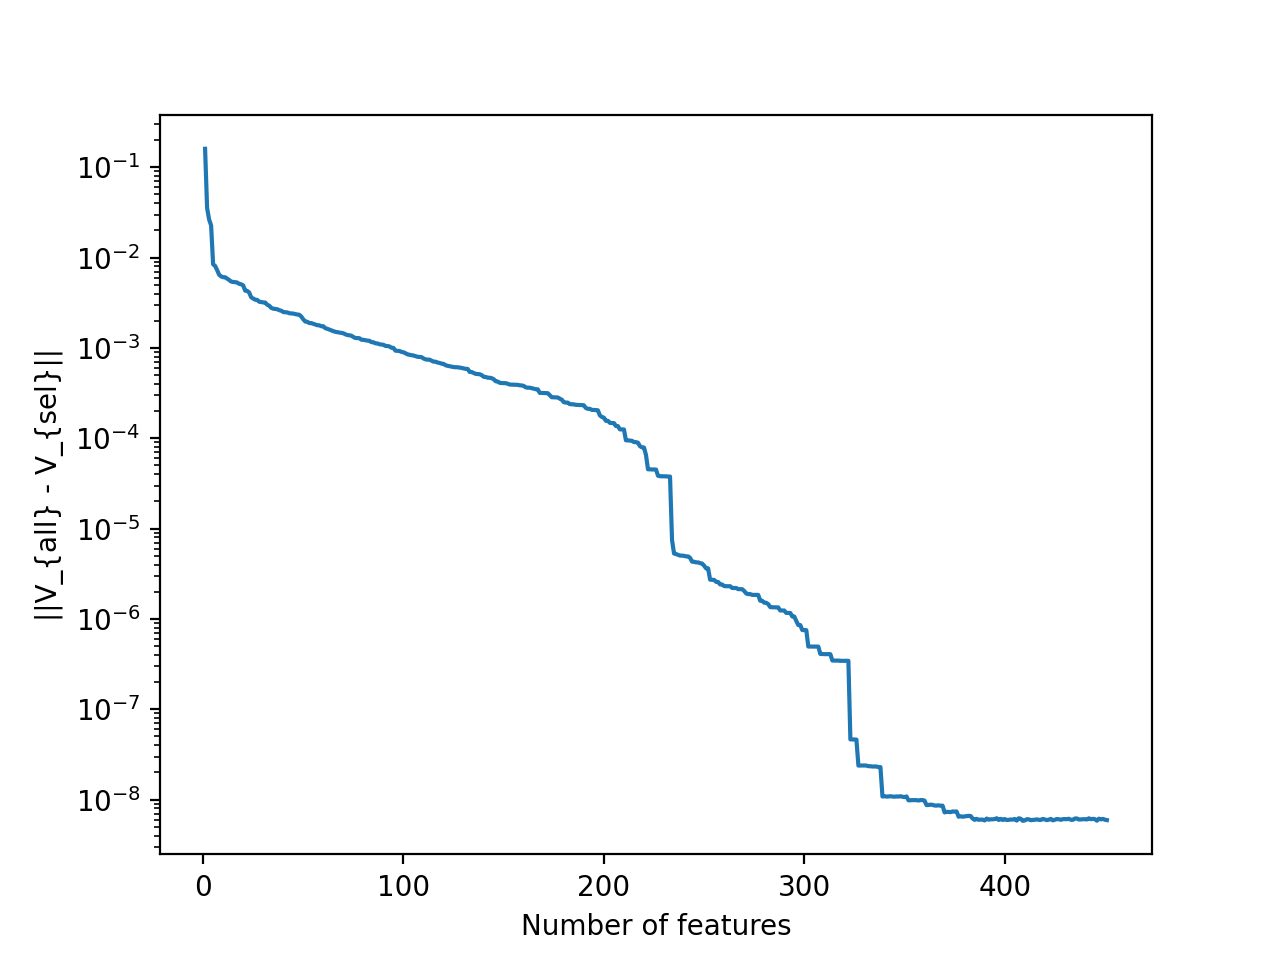

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [84]:
the_selected_cols, the_col_errors = the_SPCR.factorize(errors=True)

<IPython.core.display.Javascript object>


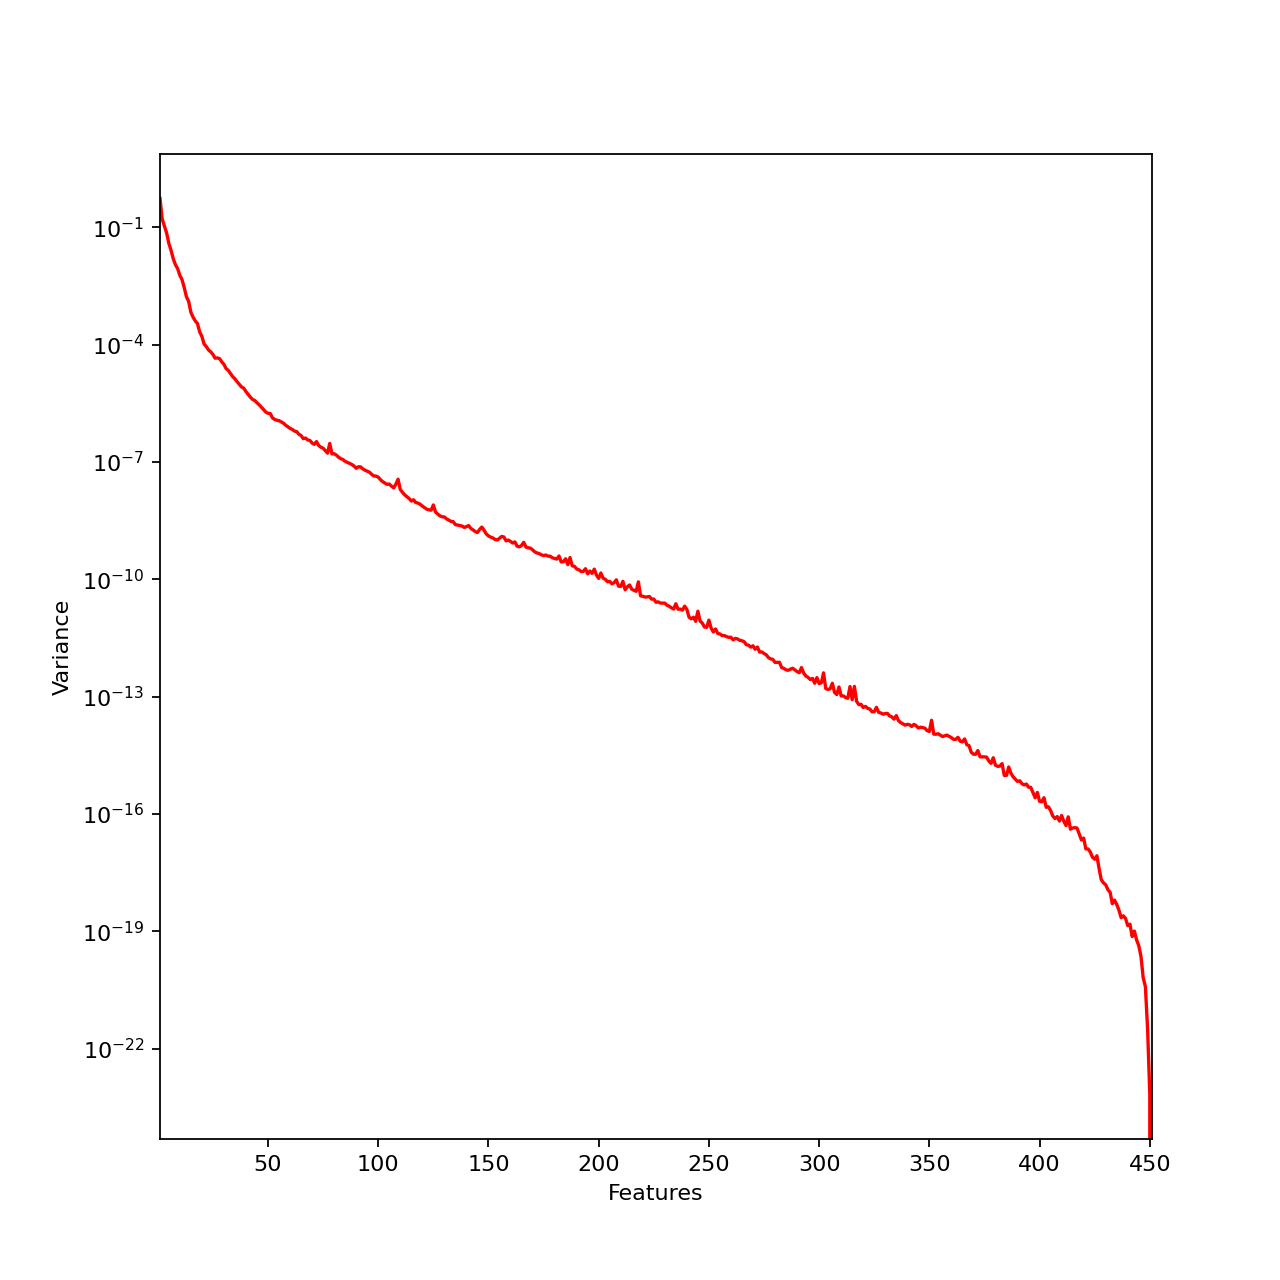

In [85]:
fig = plt.figure(figsize=(8, 8), dpi= 80,)
plt.plot(np.arange(len(the_col_errors))+1, the_col_errors, 'r-')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.yscale("log")
plt.xlim([1,len(the_col_errors)])
axes = plt.gca()
plt.show()

In [86]:
all_SPCR = SPCR(phase02_all_data)

<IPython.core.display.Javascript object>


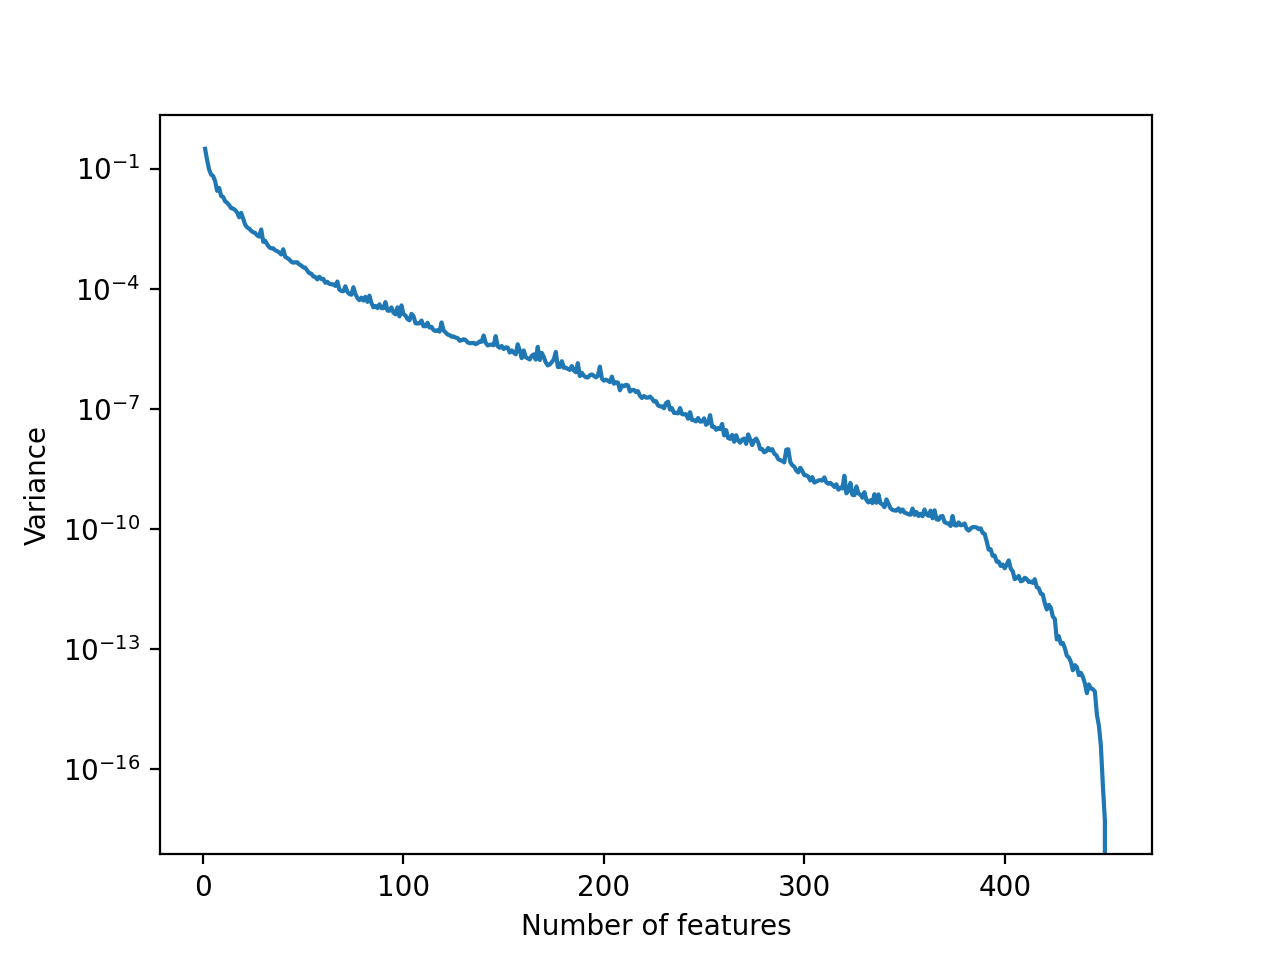

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [87]:
all_selected_cols, all_col_variance = all_SPCR.factorize()

<IPython.core.display.Javascript object>


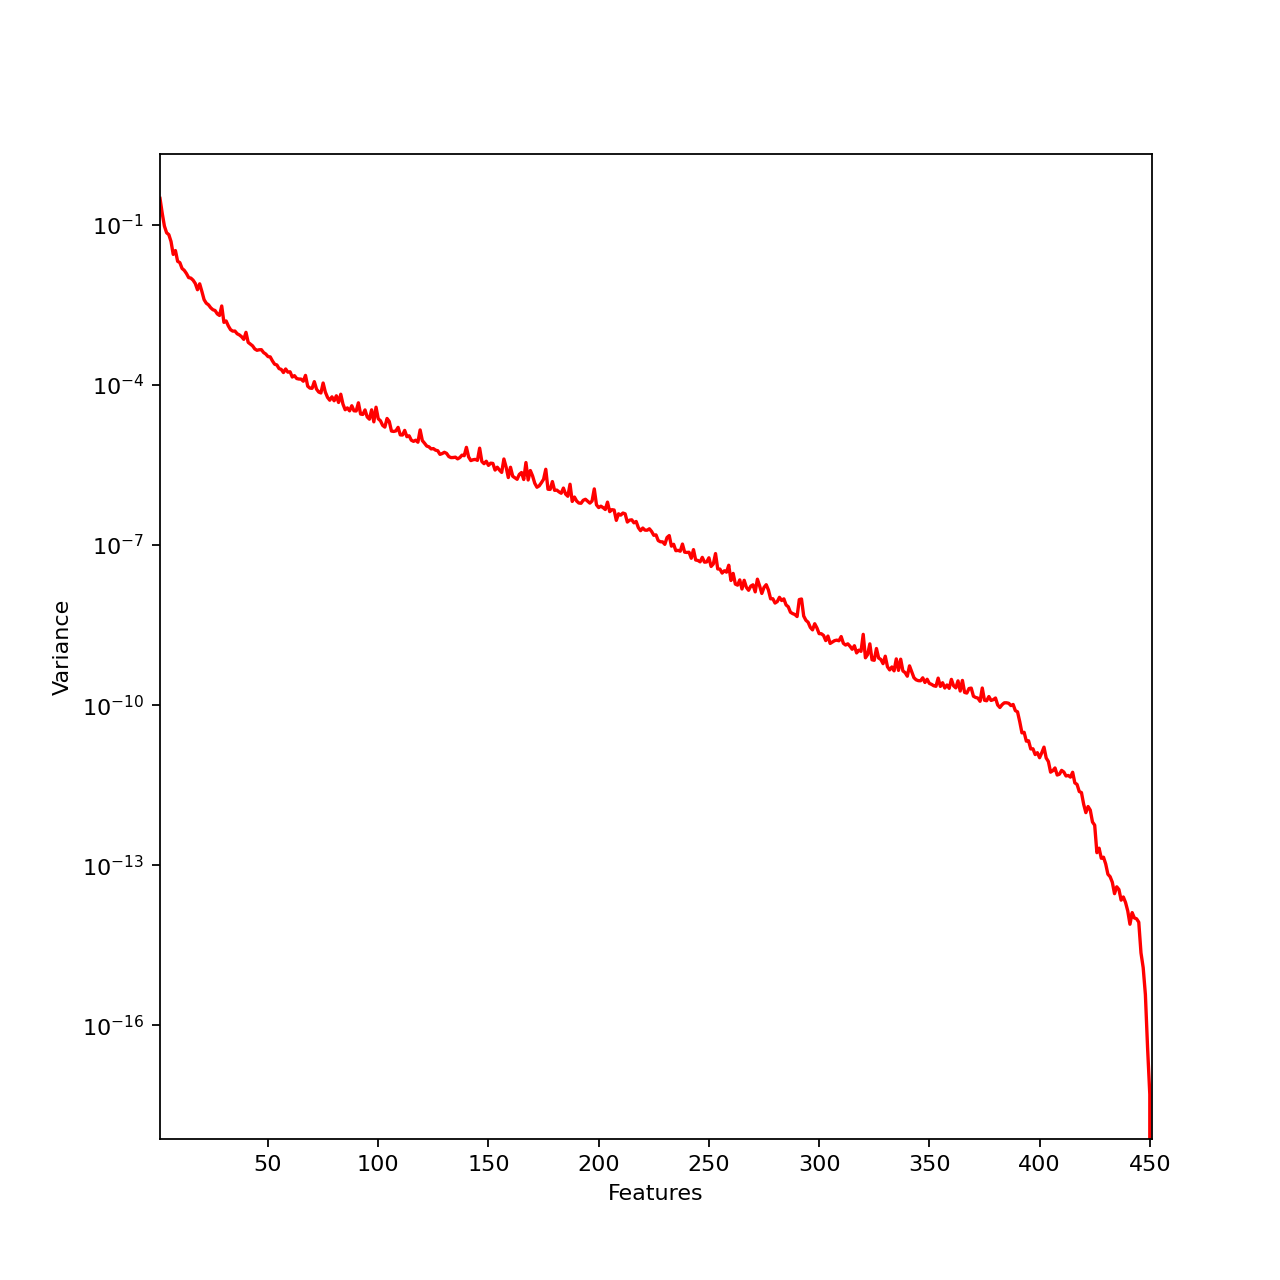

In [88]:
fig = plt.figure(figsize=(8, 8), dpi= 80,)
plt.plot(np.arange(len(all_col_variance))+1, all_col_variance, 'r-')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.yscale("log")
plt.xlim([1,len(all_col_variance)])
axes = plt.gca()
plt.show()

In [89]:
all_selected_cols[:10]

[200, 140, 130, 180, 190, 170, 100, 90, 250, 150]

In [90]:
len(all_selected_cols)

451

In [91]:
#the_CUR = FPCUR(phase02_all_data, k=1, N=phase02_all_data.shape[1], error_print=5)

In [92]:
#selections, cur_errors = the_CUR.factorize()

In [96]:
INNphase0_train = thedata.train(sublist=INNphase0_train_ids, cols=all_selected_cols[:200])
INNphase0_test = thedata.test(sublist=reduced_INNphase0_test_ids, cols=all_selected_cols[:200])
INNphase1_train = thedata.train(sublist=INNphase1_train_ids, cols=all_selected_cols[:200])
INNphase1_test = thedata.test(sublist=reduced_INNphase1_test_ids, cols=all_selected_cols[:200])
INNphase2_train = thedata.train(sublist=INNphase2_train_ids, cols=all_selected_cols[:200])
INNphase2_test = thedata.test(sublist=reduced_INNphase2_test_ids, cols=all_selected_cols[:200])

In [97]:
print(len(INNphase0_train))
print(len(INNphase0_target))

146
146


In [98]:
INNphase2_train[0].shape

torch.Size([1, 16, 200])

In [187]:
si_bulk_train = []
for fp in bulk_si_fingerprints:
    si_bulk_train.append(torch.tensor(fp["descriptors"][:,all_selected_cols[:200]], 
                                      dtype=torch.double).unsqueeze(0))

In [188]:
si_bulk_train[0].shape

torch.Size([1, 2, 200])

In [189]:
phase02_combined_train = INNphase0_train[:]
phase02_combined_train.extend(INNphase2_train)
phase02_combined_train.extend(si_bulk_train)
phase02_combined_target = torch.cat((INNphase0_target, 
                                     INNphase2_target, 
                                     torch.tensor(CASTEP_energies[CASTEP_selected])),0)

In [190]:
len(phase02_combined_train)

612

In [191]:
phase02_combined_test = INNphase0_test[:]
phase02_combined_test.extend(INNphase2_test)
phase02_combined_test_target = torch.cat((INNphase0_test_target, INNphase2_test_target),0)

In [192]:
# Build traditional ANN model
ANN = NNmodel(desc_size=200, hidden_size=32)
print(ANN)

NNmodel(
  (layer1): Linear(in_features=200, out_features=32, bias=True)
  (act1): Tanh()
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (act2): Tanh()
  (layer3): Linear(in_features=32, out_features=1, bias=True)
)


In [193]:
print("Running on ",torch.get_num_threads()," threads.")

x = phase02_combined_train
y = phase02_combined_target
tr_natoms = torch.Tensor([x[i].shape[1] for i in range(len(y))])

tx = phase02_combined_test
ty = phase02_combined_test_target
tt_natoms = torch.Tensor([tx[i].shape[1] for i in range(len(ty))])

Ntrains = 2000

# Use the nn package to define our model and loss function.
ANN.double()
loss_fn = nn.MSELoss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us.
learning_rate = 1e-3
#optimizer = torch.optim.AdamW(ANN.parameters(), lr=learning_rate, weight_decay=0.01)
optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)

Ntrains = 2000
print("Training started.")
for t in range(Ntrains):
    # Forward pass: compute predicted y by passing x to the model.
    #INN.implant()
    y_pred = ANN(x)
    
    # Compute loss.
    loss = loss_fn(y_pred, y)

    # Print loss.       
    if t % 50 == 49:
        ty_pred = ANN(tx)
        tloss = loss_fn(ty_pred, ty)
        # unit is meV
        sqrt_loss_per_atom = 1000.0 * math.sqrt(torch.mean(torch.pow(torch.div(torch.sub(y_pred,y),tr_natoms),2)))
        sqrt_tloss_per_atom = 1000.0 * math.sqrt(torch.mean(torch.pow(torch.div(torch.sub(ty_pred,ty),tt_natoms),2)))
        print("{0:d} Loss: {1:.4f} Test: {2:.4f}   RMSE(meV): {3:.3f} Test RMSE: {4:.3f}".format(
            t+1,loss.item(),tloss.item(),sqrt_loss_per_atom,sqrt_tloss_per_atom))

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

torch.save(ANN, 'ANN_save_0.pth')

Running on  6  threads.
Training started.
50 Loss: 155.4576 Test: 134.9631   RMSE(meV): 195.103 Test RMSE: 185.662
100 Loss: 101.4233 Test: 88.7267   RMSE(meV): 140.372 Test RMSE: 138.011
150 Loss: 60.9106 Test: 49.3825   RMSE(meV): 113.363 Test RMSE: 114.044
200 Loss: 29.1591 Test: 23.0877   RMSE(meV): 87.981 Test RMSE: 92.162
250 Loss: 6.3255 Test: 4.8540   RMSE(meV): 58.932 Test RMSE: 64.564
300 Loss: 2.2890 Test: 1.8165   RMSE(meV): 46.815 Test RMSE: 50.649
350 Loss: 1.6582 Test: 1.4722   RMSE(meV): 40.847 Test RMSE: 43.843
400 Loss: 1.3870 Test: 1.3075   RMSE(meV): 37.725 Test RMSE: 39.962
450 Loss: 1.2505 Test: 1.1980   RMSE(meV): 36.087 Test RMSE: 37.818
500 Loss: 1.1616 Test: 1.1295   RMSE(meV): 35.142 Test RMSE: 36.577
550 Loss: 1.0958 Test: 1.0734   RMSE(meV): 34.472 Test RMSE: 35.732
600 Loss: 1.0435 Test: 1.0274   RMSE(meV): 33.969 Test RMSE: 35.134
650 Loss: 1.0004 Test: 0.9906   RMSE(meV): 33.571 Test RMSE: 34.692
700 Loss: 0.9689 Test: 0.9735   RMSE(meV): 33.256 Test RMS

In [194]:
INN = NNmodel(desc_size=200, hidden_size=8)
print(INN)

NNmodel(
  (layer1): Linear(in_features=200, out_features=8, bias=True)
  (act1): Tanh()
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (act2): Tanh()
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)


In [195]:
params = list(INN.parameters())
print(len(params))
print(params[0].shape)
# Activation layers do not have weights!
# Layer =  Weights + Bias
# We have 3 layers

6
torch.Size([8, 200])


In [196]:
phase0_combined_train = INNphase0_train[:]
phase0_combined_train.extend(si_bulk_train)
phase0_combined_target = torch.cat((INNphase0_target, 
                                     torch.tensor(CASTEP_energies[CASTEP_selected])),0)

In [197]:
print("Running on ",torch.get_num_threads()," threads.")

x = phase0_combined_train
y = phase0_combined_target
tr_natoms = torch.Tensor([x[i].shape[1] for i in range(len(y))])

tx = INNphase0_test
ty = INNphase0_test_target
tt_natoms = torch.Tensor([tx[i].shape[1] for i in range(len(ty))])

INN.double()
loss_fn = nn.MSELoss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us.
learning_rate = 1e-2
#optimizer = torch.optim.AdamW(INN.parameters(), lr=learning_rate, weight_decay=0.01)
optimizer = torch.optim.Adam(INN.parameters(), lr=learning_rate)

Ntrains = 3000

for t in range(Ntrains):
    # Forward pass: compute predicted y by passing x to the model.
    #INN.implant()
    y_pred = INN(x)
    
    # Compute loss.
    loss = loss_fn(y_pred, y)

    # Print loss.       
    if t % 100 == 99:
        ty_pred = INN(tx)
        tloss = loss_fn(ty_pred, ty)
        # unit is meV
        sqrt_loss_per_atom = 1000.0 * math.sqrt(torch.mean(torch.pow(torch.div(torch.sub(y_pred,y),tr_natoms),2)))
        sqrt_tloss_per_atom = 1000.0 * math.sqrt(torch.mean(torch.pow(torch.div(torch.sub(ty_pred,ty),tt_natoms),2)))
        print("{0:d} Loss: {1:.4f} Test: {2:.4f}   RMSE(meV): {3:.3f} Test RMSE: {4:.3f}".format(
            t+1,loss.item(),tloss.item(),sqrt_loss_per_atom,sqrt_tloss_per_atom))

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

torch.save(INN, 'INN_save_2.pth')

Running on  6  threads.
100 Loss: 0.0413 Test: 0.0461   RMSE(meV): 40.376 Test RMSE: 40.671
200 Loss: 0.0218 Test: 0.0166   RMSE(meV): 28.693 Test RMSE: 37.517
300 Loss: 0.0177 Test: 0.0192   RMSE(meV): 27.819 Test RMSE: 36.339
400 Loss: 0.0157 Test: 0.0160   RMSE(meV): 27.408 Test RMSE: 35.338
500 Loss: 0.0141 Test: 0.0168   RMSE(meV): 27.118 Test RMSE: 34.679
600 Loss: 0.0160 Test: 0.0149   RMSE(meV): 26.888 Test RMSE: 34.003
700 Loss: 0.0125 Test: 0.0166   RMSE(meV): 26.640 Test RMSE: 33.604
800 Loss: 0.0137 Test: 0.0203   RMSE(meV): 26.440 Test RMSE: 33.134
900 Loss: 0.0116 Test: 0.0165   RMSE(meV): 26.246 Test RMSE: 32.827
1000 Loss: 0.0110 Test: 0.0160   RMSE(meV): 26.014 Test RMSE: 32.345
1100 Loss: 0.0462 Test: 0.0502   RMSE(meV): 26.159 Test RMSE: 32.223
1200 Loss: 0.0105 Test: 0.0156   RMSE(meV): 25.660 Test RMSE: 31.774
1300 Loss: 0.0101 Test: 0.0154   RMSE(meV): 25.432 Test RMSE: 31.330
1400 Loss: 0.5198 Test: 0.3758   RMSE(meV): 33.773 Test RMSE: 39.631
1500 Loss: 0.0097 T

In [198]:
INN1 = torch.load('INN_save_2.pth')

In [199]:
INN2 = NNmodel(desc_size=200, hidden_size=18, implant_net=INN1)
print(INN2)

NNmodel(
  (layer1): Linear(in_features=200, out_features=26, bias=True)
  (act1): Tanh()
  (layer2): Linear(in_features=26, out_features=26, bias=True)
  (act2): Tanh()
  (layer3): Linear(in_features=26, out_features=1, bias=True)
)


In [200]:
print("Running on ",torch.get_num_threads()," threads.")

x = phase02_combined_train
y = phase02_combined_target
tr_natoms = torch.Tensor([x[i].shape[1] for i in range(len(y))])

tx = phase02_combined_test
ty = phase02_combined_test_target
tt_natoms = torch.Tensor([tx[i].shape[1] for i in range(len(ty))])

INN2.double()
loss_fn = nn.MSELoss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us.
learning_rate = 1e-3
optimizer = torch.optim.AdamW(INN2.parameters(), lr=learning_rate, weight_decay=0.01)

Ntrains = 2000

for t in range(Ntrains):
    # Forward pass: compute predicted y by passing x to the model.
    #INN.implant()
    y_pred = INN2(x)
    
    # Compute loss.
    loss = loss_fn(y_pred, y)
        
    # Print loss.       
    if t % 50 == 49:
        ty_pred = INN2(tx)
        tloss = loss_fn(ty_pred, ty)
        # unit is meV
        sqrt_loss_per_atom = 1000.0 * math.sqrt(torch.mean(torch.pow(torch.div(torch.sub(y_pred,y),tr_natoms),2)))
        sqrt_tloss_per_atom = 1000.0 * math.sqrt(torch.mean(torch.pow(torch.div(torch.sub(ty_pred,ty),tt_natoms),2)))
        print("{0:d} Loss: {1:.4f} Test: {2:.4f}   RMSE(meV): {3:.3f} Test RMSE: {4:.3f}".format(
            t+1,loss.item(),tloss.item(),sqrt_loss_per_atom,sqrt_tloss_per_atom))


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

torch.save(INN2, 'INN_save_3.pth')

Running on  6  threads.
50 Loss: 85.5684 Test: 79.5468   RMSE(meV): 146.778 Test RMSE: 146.267
100 Loss: 67.8373 Test: 59.9421   RMSE(meV): 125.151 Test RMSE: 124.142
150 Loss: 36.1349 Test: 29.8821   RMSE(meV): 79.204 Test RMSE: 77.557
200 Loss: 16.1596 Test: 10.8206   RMSE(meV): 55.869 Test RMSE: 51.194
250 Loss: 6.4589 Test: 3.9118   RMSE(meV): 41.052 Test RMSE: 37.968
300 Loss: 3.2296 Test: 2.0598   RMSE(meV): 38.010 Test RMSE: 34.841
350 Loss: 2.2718 Test: 1.6584   RMSE(meV): 36.337 Test RMSE: 33.144
400 Loss: 1.7058 Test: 1.3889   RMSE(meV): 34.489 Test RMSE: 31.650
450 Loss: 1.3587 Test: 1.1998   RMSE(meV): 33.411 Test RMSE: 30.936
500 Loss: 1.1633 Test: 1.0801   RMSE(meV): 32.965 Test RMSE: 30.778
550 Loss: 1.0596 Test: 1.0080   RMSE(meV): 32.854 Test RMSE: 30.872
600 Loss: 1.0032 Test: 0.9641   RMSE(meV): 32.851 Test RMSE: 31.013
650 Loss: 0.9680 Test: 0.9357   RMSE(meV): 32.840 Test RMSE: 31.109
700 Loss: 0.9414 Test: 0.9157   RMSE(meV): 32.786 Test RMSE: 31.142
750 Loss: 0.9

In [201]:
def Murnaghan(parameters, vol):
    'From Phys. Rev. B 28, 5480 (1983)'
    E0, B0, BP, V0 = parameters

    E = E0 + B0 * vol / BP * (((V0 / vol)**BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.0)

    return E

def objective(pars, y, x):
    #we will minimize this function
    err =  y - Murnaghan(pars, x)
    return err

def bulk_modulus(vols, energies, cell_size):
    '''
    V0 = minimum energy volume, or where dE/dV=0
    E = aV^2 + bV + c
    dE/dV = 2aV + b = 0
    V0 = -b/2a
    
    E0 is the minimum energy, which is:
    E0 = aV0^2 + bV0 + c
    
    B is equal to V0*d^2E/dV^2, which is just 2a*V0
    '''
    a, b, c = polyfit(vols, energies, 2)
    v0 = -b / (2 * a)
    e0 = a * v0 ** 2 + b * v0 + c
    b0 = 2 * a * v0
    bP = 4
    x0 = [ e0, b0, bP, v0] #initial guess of parameters
    plsq = leastsq(objective, x0, args=(energies, vols))
    BmodGPa = plsq[0][1] * 160.2176487
    print('Bulk Modulus in GPa: {0}'.format(BmodGPa))
    alen = (plsq[0][3]/np.prod(cell_size)) ** (1 / 3.0)
    print('Equlibrium lattice constant: {0}'.format(alen))
    
    plt.plot(vols,energies, 'ro')
    x = np.linspace(min(vols), max(vols), 50)
    y = Murnaghan(plsq[0], x)
    plt.plot(x, y, 'k-')
    plt.xlabel('Volume (A^3)')
    plt.ylabel('Energy (eV)')
    plt.show()


In [202]:
sigma = 0.5
cutoff = 6.5 # <-- check this value before start!!!
rad_n_max = 9
ang_l_max = 9
normalise = True
cross_over = True

#soap_desc = soaplite.get_soap_structure
desc_definition = ("soap" 
                   " cutoff=" + str(cutoff) +
                   " l_max=" + str(ang_l_max) +
                   " n_max=" + str(rad_n_max) +
                   " atom_sigma=" + str(sigma) +
                   " normalise=" + ('T' if normalise else 'F') + 
                   " n_Z=" + str(len(all_nums)) +
                   " Z={" + " ".join([str(nm) for nm in all_nums]) + "}" + 
                   " n_species=" + str(len(all_nums)) +
                   " species_Z={" + " ".join([str(nm) for nm in all_nums]) + "}")
soap_desc = descriptors.Descriptor(desc_definition)
desc_definition

'soap cutoff=6.5 l_max=9 n_max=9 atom_sigma=0.5 normalise=T n_Z=1 Z={14} n_species=1 species_Z={14}'

In [216]:
V0 = si_bulk_dia.get_volume()
dV = 0.025
nsteps = [-5, 6]
dV *= V0
ann_pred_list = []
inn_pred_list = []
lata_list = []

scaled_bulk = si_bulk_dia.copy()
for i in range(0, nsteps[0]-1, -1):
    V_cur = scaled_bulk.get_volume()
    scaled_bulk.set_cell(scaled_bulk.get_cell()*((V0+i*dV)/V_cur)**(1.0/3.0), scale_atoms=True)
    
    fingerprints = calc_desc([scaled_bulk], soap_desc, 
                             cutoff, rad_n_max, ang_l_max, 
                             all_elements, silent=True)
    database = select_db_element(fingerprints)
    desc_input = torch.tensor(database[:,all_selected_cols[:200]], dtype=torch.double).unsqueeze(0)
    ANN_pred = ANN([desc_input])
    INN_pred = INN2([desc_input])
    ann_pred_list.insert(0, ANN_pred[0].item())
    inn_pred_list.insert(0, INN_pred[0].item())    
    lata_list.insert(0, (scaled_bulk.get_volume()/len(scaled_bulk) ) )
                  
scaled_bulk = si_bulk_dia.copy()
for i in range(1, nsteps[1]+1):
    V_cur = scaled_bulk.get_volume()
    scaled_bulk.set_cell(scaled_bulk.get_cell()*((V0+i*dV)/V_cur)**(1.0/3.0), scale_atoms=True)
    fingerprints = calc_desc([scaled_bulk], soap_desc, 
                             cutoff, rad_n_max, ang_l_max, 
                             all_elements, silent=True)
    database = select_db_element(fingerprints)
    desc_input = torch.tensor(database[:,all_selected_cols[:200]], dtype=torch.double).unsqueeze(0)
    ANN_pred = ANN([desc_input])
    INN_pred = INN2([desc_input])
    ann_pred_list.append(ANN_pred[0].item())
    inn_pred_list.append(INN_pred[0].item())    
    lata_list.append((scaled_bulk.get_volume()/len(scaled_bulk) ) )


<IPython.core.display.Javascript object>


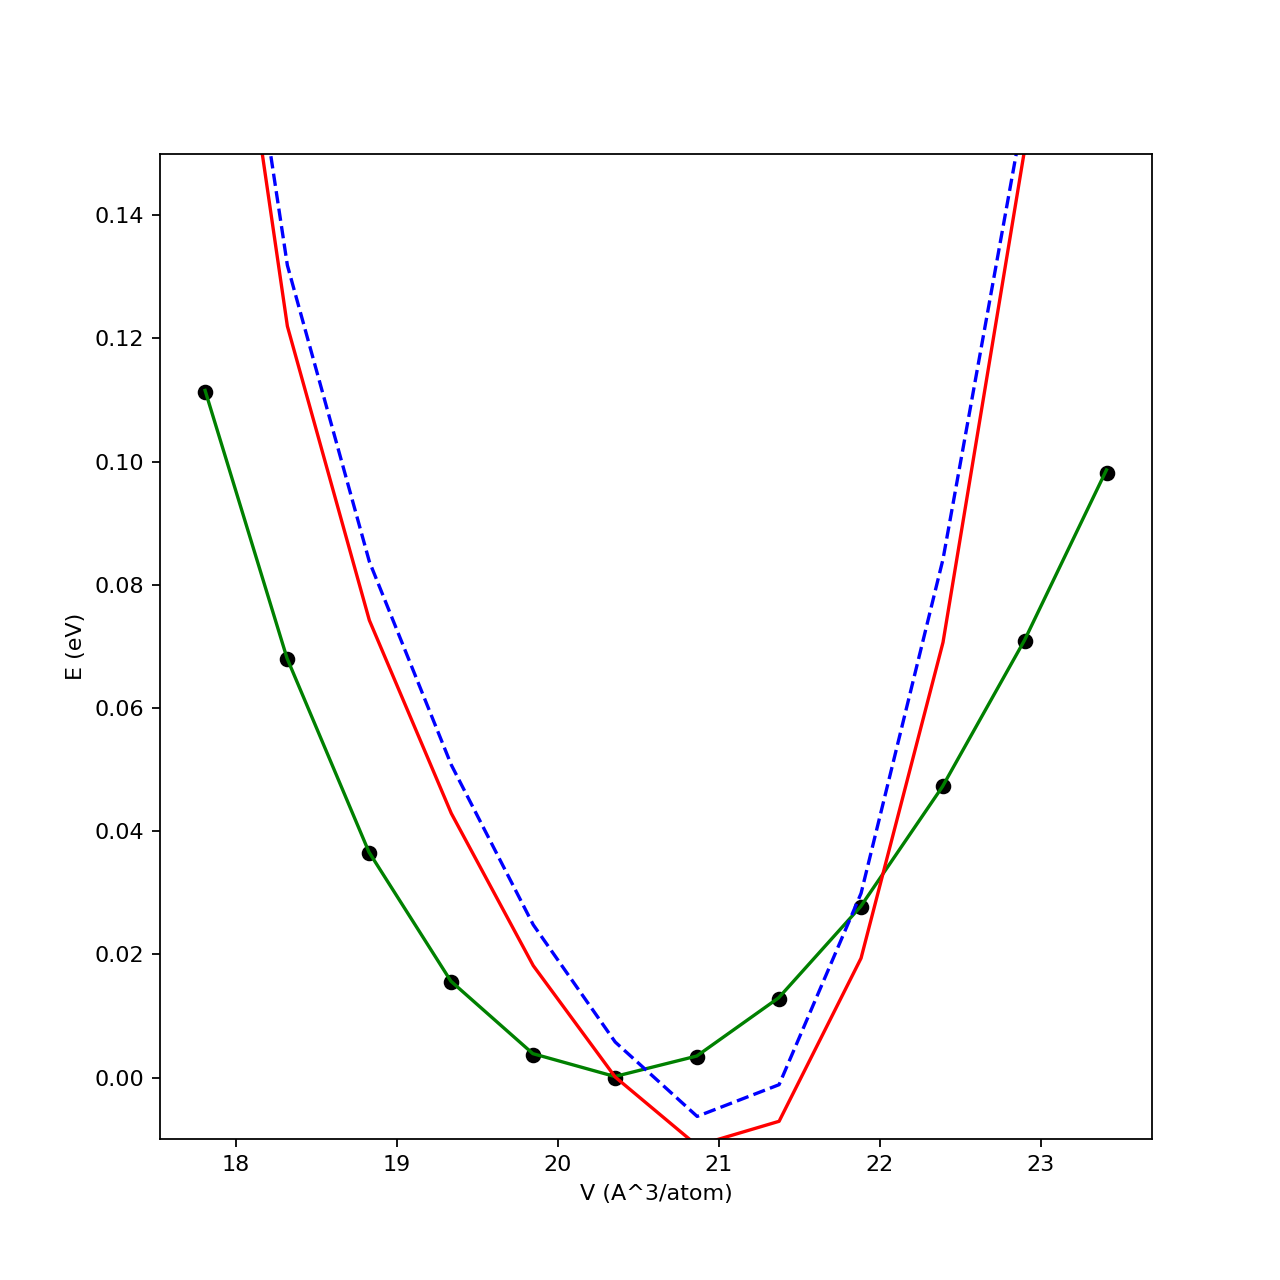

In [217]:
vols=np.asarray(lata_list)
ann_energies=np.asarray(ann_pred_list)
inn_energies=np.asarray(inn_pred_list)
CASTEP_energies = np.array(CASTEP_Si_diamond_properties["E_vs_V"])
GAP_energies = np.array(GAP_Si_diamond_properties["E_vs_V"])
fig = plt.figure(figsize=(8, 8), dpi= 80,)
plt.plot(CASTEP_energies[:,0],CASTEP_energies[:,1]-bulk_ref_1, 'ko', linewidth=3)
plt.plot(GAP_energies[:,0],GAP_energies[:,1]-bulk_ref_1, 'g-')
plt.plot(vols, ann_energies, 'b--')
plt.plot(vols, inn_energies, 'r-')
plt.xlabel('V (A^3/atom)')
plt.ylabel('E (eV)')
axes = plt.gca()
axes.set_ylim([-0.01,0.15])
plt.show()

In [205]:
bulk_modulus(CASTEP_energies[:,0], CASTEP_energies[:,1], (1,1,1))

Bulk Modulus in GPa: 87.65385491582379
Equlibrium lattice constant: 2.7306410776316303


In [206]:
bulk_modulus(GAP_energies[:,0], GAP_energies[:,1], (1,1,1))

Bulk Modulus in GPa: 87.77800753640415
Equlibrium lattice constant: 2.730657733516508


In [207]:
bulk_modulus(vols, inn_energies, (1,1,1))

Bulk Modulus in GPa: 221.67510775822728
Equlibrium lattice constant: 2.748259945801503


In [208]:
bulk_modulus(vols, ann_energies, (1,1,1))

Bulk Modulus in GPa: 204.9925393679462
Equlibrium lattice constant: 2.7446841453054067
